# Visualize longer timeseries outputted by the UNIX `ping` command

I've pinged the immigration site and official site of the goverment of Canada during the most intensive 2 days of the US presidential elections. My observation wasn't constant, but I've tried to made the measurement as continuous as possible. I've also measured the latency of the subdomain `physics.my.pebble.host` (IP `217.182.158.180`) for a single day. I've created a custom `bash` script to be able to ping an arbitrary target IP/domain, which is the following:

```sh
#!/usr/bin/bash
PATH="/home/masterdesky/Documents/GitHub/ELTE_Info_Com_Mod_2021/practice/data/"

while test $# -gt 0; do
  case "$1" in
    -h|--help)
      echo "ping - attempt to capture frames"
      echo " "
      echo "ping [options]"
      echo " "
      echo "options:"
      echo "-h, --help                show brief help"
      echo "-t, --target=TARGET       specify the target to be pinged"
      echo "-o, --output=OUTPUT       specify the output file's name"
      exit 0
      ;;
    -t)
      shift
      if test $# -gt 0; then
        export TARGET=$1
      else
        echo "no target specified"
        exit 1
      fi
      shift
      ;;
    --target*)
      export TARGET=`echo $1'`
      shift
      ;;
    -o)
      shift
      if test $# -gt 0; then
        export OUTPUT=$1
      else
        echo "no output file specified"
        exit 1
      fi
      shift
      ;;
    --output*)
      export OUTPUT=`echo $1`
      shift
      ;;
    *)
      break
      ;;
  esac
done

echo "Pinging target... $TARGET"
echo "Writing files to $PATH$OUTPUT"

/usr/bin/ping -D -i 1 -s 32 "$TARGET" |& /usr/bin/tee "$PATH$OUTPUT"
```

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
data = './data/'

### Just some matplotlib and seaborn parameter tuning

In [3]:
fig_x = 30
fig_y = 11
axistitlesize = 22
axisticksize_date = 13
axisticksize_y = 18
axislabelsize = 30
axistextsize = 14
axislegendsize = 25
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')
rocket_cmap = sns.color_palette('rocket', as_cmap=True)

## 1. Preprocess data

### Read ping files

In [4]:
os.listdir(data)

['www_elte_hu.txt',
 'fizika_mc_3.txt',
 'fizika_mc.txt',
 'immigration_ca_ping_2.txt',
 'fizika_mc_2.txt',
 'canada_ca_ping.txt',
 'universities',
 'canada_ca_ping_2.txt',
 'immigration_ca_ping.txt']

In [16]:
def read_ping_file(file_name):
    
    dc = []
    with open(data + file_name, 'r') as f:
        header = f.readline()
        if header != '':
            print(header)
        for i, line in enumerate(f):
            # Skip faulty lines
            if\
            ('unreachable' in line.lower()
             or
             'packet filtered' in line.lower()
             or
             'time to live exceeded' in line.lower()
             or
             'destination host prohibited' in line.lower()
            ):
                continue
            if line == '\n':
                break
            line = line.replace(' (DUP!)', '')
            elems = line.split(' ')
            try:
                ts = float(elems[0].strip('[]'))        # Unix timestamp
                ts = datetime.utcfromtimestamp(ts)      # Create datetime values
                b = float(elems[1])                     # Packet size used to ping host
                h = header.split(' ')[1]                # Pinged host's name
                hip = header.split(' ')[2].strip('()')  # Pinged host's IP address
                p = float(elems[-2].strip('time='))     # Ping in ms
                dc.append([ts, b, h, hip, p])
            except:
                print(line)
    df = pd.DataFrame(data=dc, columns=['Timestamp',
                                        'Packet size [byte]',
                                        'Host name',
                                        'Host IP',
                                        'Ping [ms]'])
    return df, header

In [18]:
# canada.ca
df_1_1, header_1 = read_ping_file(file_name='canada_ca_ping.txt')
df_1_2, _ = read_ping_file(file_name='canada_ca_ping_2.txt')
df_1 = pd.concat([df_1_1, df_1_2], ignore_index=True)

# immigration.ca
df_2_1, header_2 = read_ping_file(file_name='immigration_ca_ping.txt')
df_2_2, _ = read_ping_file(file_name='immigration_ca_ping_2.txt')
df_2 = pd.concat([df_2_1, df_2_2], ignore_index=True)

# FizikaMC
df_3_1, header_3 = read_ping_file(file_name='fizika_mc.txt')
df_3_2, _ = read_ping_file(file_name='fizika_mc_2.txt')
df_3_3, _ = read_ping_file(file_name='fizika_mc_3.txt')
df_3 = pd.concat([df_3_1, df_3_2, df_3_3], ignore_index=True)

PING canada.ca (205.193.215.159) 56(84) bytes of data.

PING canada.ca (205.193.215.159) 56(84) bytes of data.

PING immigration.ca (104.26.2.199) 56(84) bytes of data.

PING immigration.ca (104.26.2.199) 56(84) bytes of data.

PING physics.my.pebble.host (217.182.158.180) 32(60) bytes of data.

PING 217.182.158.180 (217.182.158.180) 32(60) bytes of data.

PING 217.182.158.180 (217.182.158.180) 32(60) bytes of data.



### Create appropriate date ticks

In [19]:
from matplotlib import ticker
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.ticker as plticker

In [20]:
date_format = mdates.DateFormatter('%b %d \'%y - %H:%M')

In [21]:
def create_date_ticks(df, N=22):
    """
    Create a list of string date ticks to use them on a figure.
    """
    dates = df['Timestamp']
    date_ticks = pd.date_range(min(dates), max(dates), periods=N).to_numpy()
    
    return date_ticks

## 2./a. Visualize time series of individual pings

In [27]:
def visualize_ping_series(df, header=None,
                          base=5.0):
    
    fig, axes = plt.subplots(figsize=(fig_x,fig_y),
                             facecolor='black', subplot_kw={'facecolor' : 'black'})
    
    sr = 3
    x = df['Timestamp']
    y = df['Ping [ms]']
    c = cm.magma(y/y.max()/2 + 0.5)
    axes.scatter(x, y,
                 c=c, alpha=0.4, s=sr**2)

    # Title to display header if exists
    axes.set_title(header, fontsize=axistitlesize, fontweight='bold',
                   color='white')
    
    # X ticks denoting timestamps
    date_ticks = create_date_ticks(df, N=20)
    axes.set_xticks(date_ticks)
    axes.set_xticklabels(date_ticks, rotation=62, ha='center')
    axes.xaxis.set_major_formatter(date_format)
    axes.set_xlim(date_ticks[0], date_ticks[-1])
    
    xlabel = 'Timestamp of ping | Target : {0}'.format(df['Host IP'].values[0])
    axes.set_xlabel(xlabel, fontsize=axislabelsize, fontweight='bold',
                    color='white')
    axes.tick_params(axis='x', which='major', labelsize=axisticksize_date,
                     colors='white', pad=10)
    
    # Y ticks denoting ping in [ms]
    loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
    axes.yaxis.set_major_locator(loc)
    axes.set_ylabel('Ping [ms]', fontsize=axislabelsize, fontweight='bold',
                    color='white')
    axes.tick_params(axis='y', which='major', labelsize=axisticksize_y,
                     colors='white', pad=10)

    plt.show()

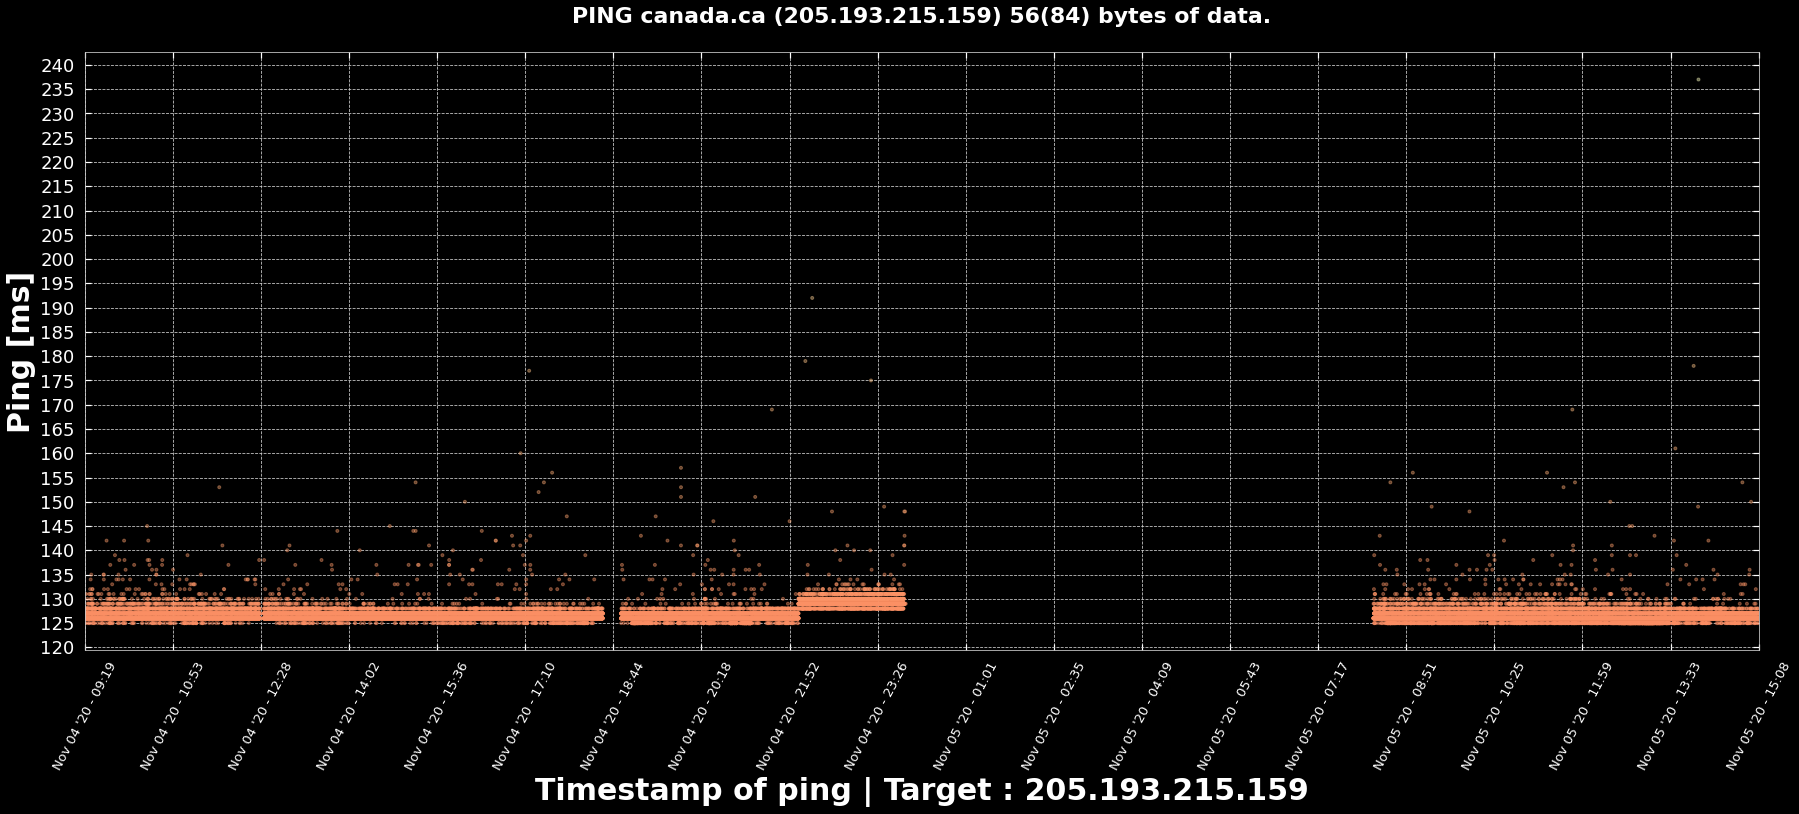

In [28]:
visualize_ping_series(df=df_1, header=header_1)

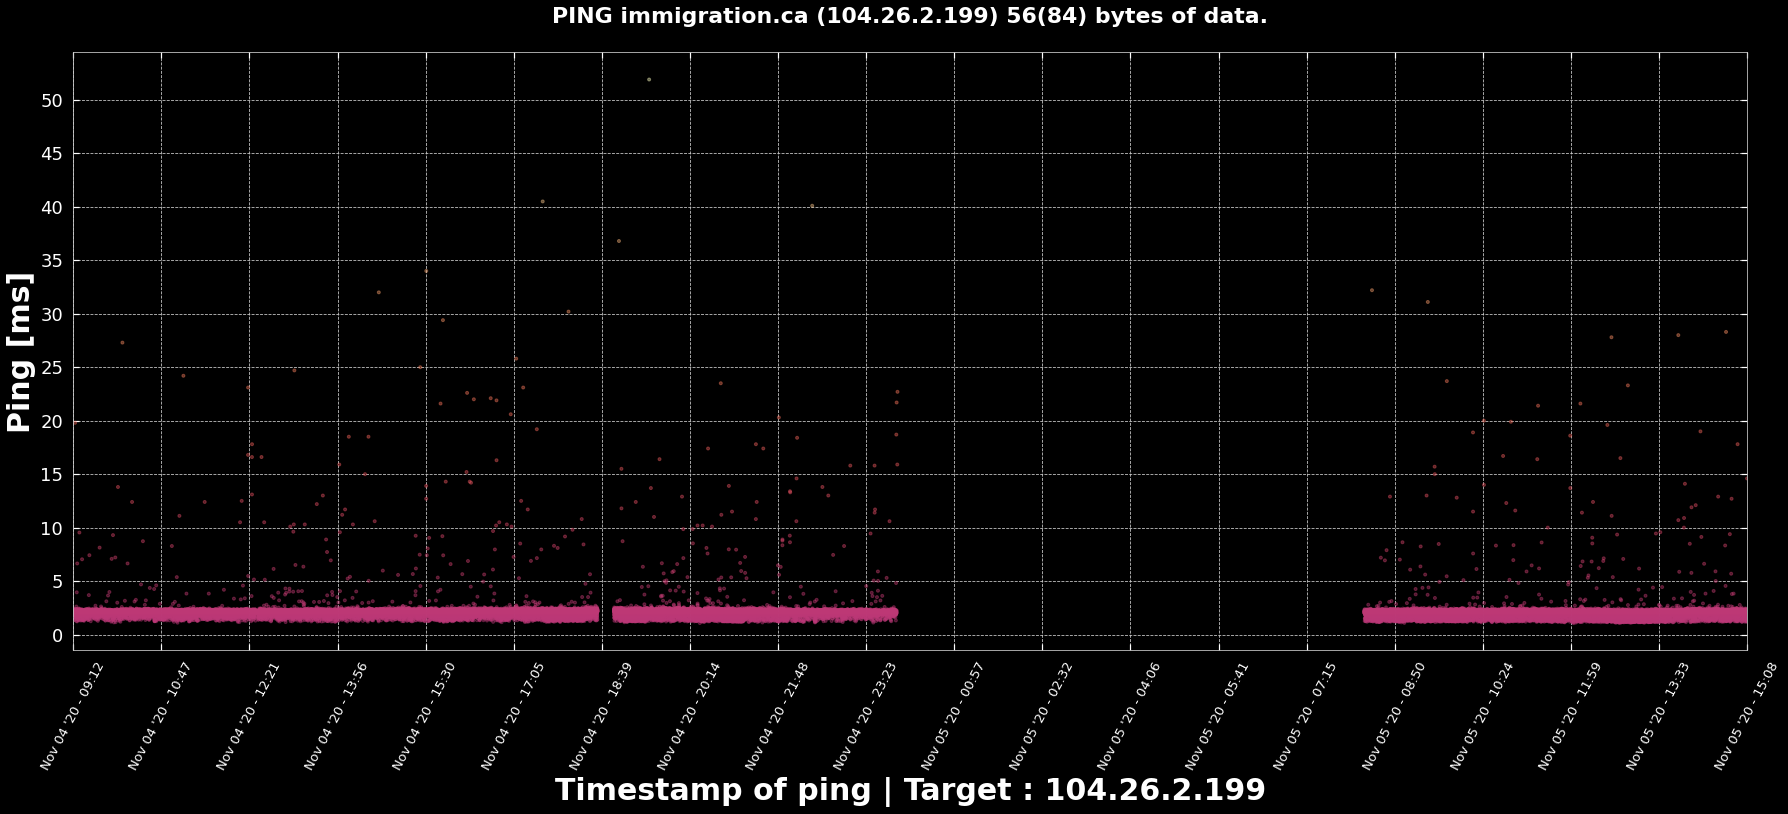

In [29]:
visualize_ping_series(df=df_2, header=header_2)

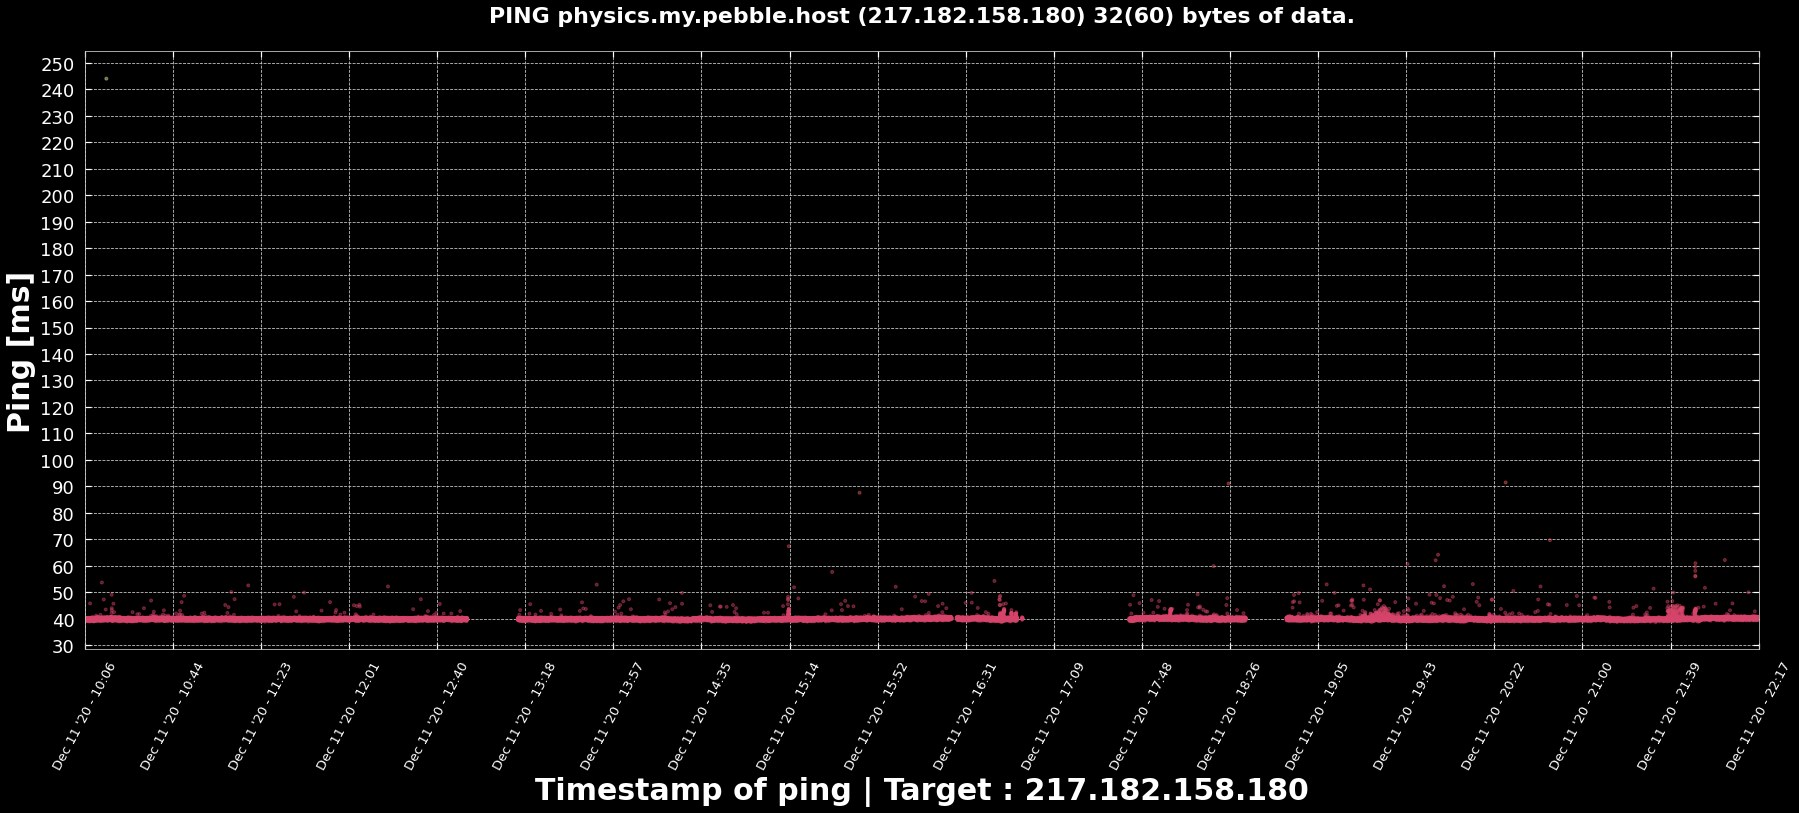

In [30]:
visualize_ping_series(df=df_3, header=header_3, base=10)

## 2./b. Visualize histogram of pings

In [31]:
from scipy.stats import gaussian_kde

In [32]:
def visualize_ping_histograms(df, header=None, bins=20):
    
    fig, axes = plt.subplots(figsize=(fig_x,fig_y),
                             facecolor='black', subplot_kw={'facecolor' : 'black'})
    # Obviously use a logarithmic y axis
    axes.set_yscale('log')
    
    x = df['Ping [ms]']
    
    # Create histogram
    hist, bins = np.histogram(x, bins=bins, density=True)
    width = 1 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    
    # Calculate KDE
    # Create density plot
    density = gaussian_kde(x)
    density.covariance_factor = lambda : 0.25
    density._compute_covariance()
    xs = np.linspace(int(x.min()), int(x.max()) + 1, 100)
    ys = density(xs)
    
    axes.bar(center, hist / hist.sum(), width=width, label='Histogram with {} bins'.format(len(hist)),
             color=cm.magma(0.93), ec='black', alpha=0.8)
    axes.plot(xs, (ys / hist.sum()), label='Gaussian KDE',
          color=rocket_cmap(0.65), lw=5, ls='-', alpha=0.6)
    
    # Title to display header if exists
    axes.set_title(header, fontsize=axistitlesize, fontweight='bold',
                   color='white')
    
    # X ticks denoting ping in [ms]
    loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
    axes.xaxis.set_major_locator(loc)
    xlabel = 'Ping [ms] | Target : {0}'.format(df['Host IP'].values[0])
    axes.set_xlabel(xlabel, fontsize=axislabelsize, fontweight='bold',
                    color='white')
    axes.tick_params(axis='x', which='major', labelsize=axisticksize_y,
                     colors='white', pad=10, labelrotation=42)
    
    # Y ticks denoting relative occurence of pings
    axes.set_ylabel('Relative occurence', fontsize=axislabelsize, fontweight='bold',
                    color='white')
    axes.tick_params(axis='y', which='major', labelsize=axisticksize_y,
                     colors='white', pad=10)
    axes.set_ylim(1e-6, 1.1)

    axes.legend(loc='upper right', fontsize=axislegendsize)
    
    plt.show()

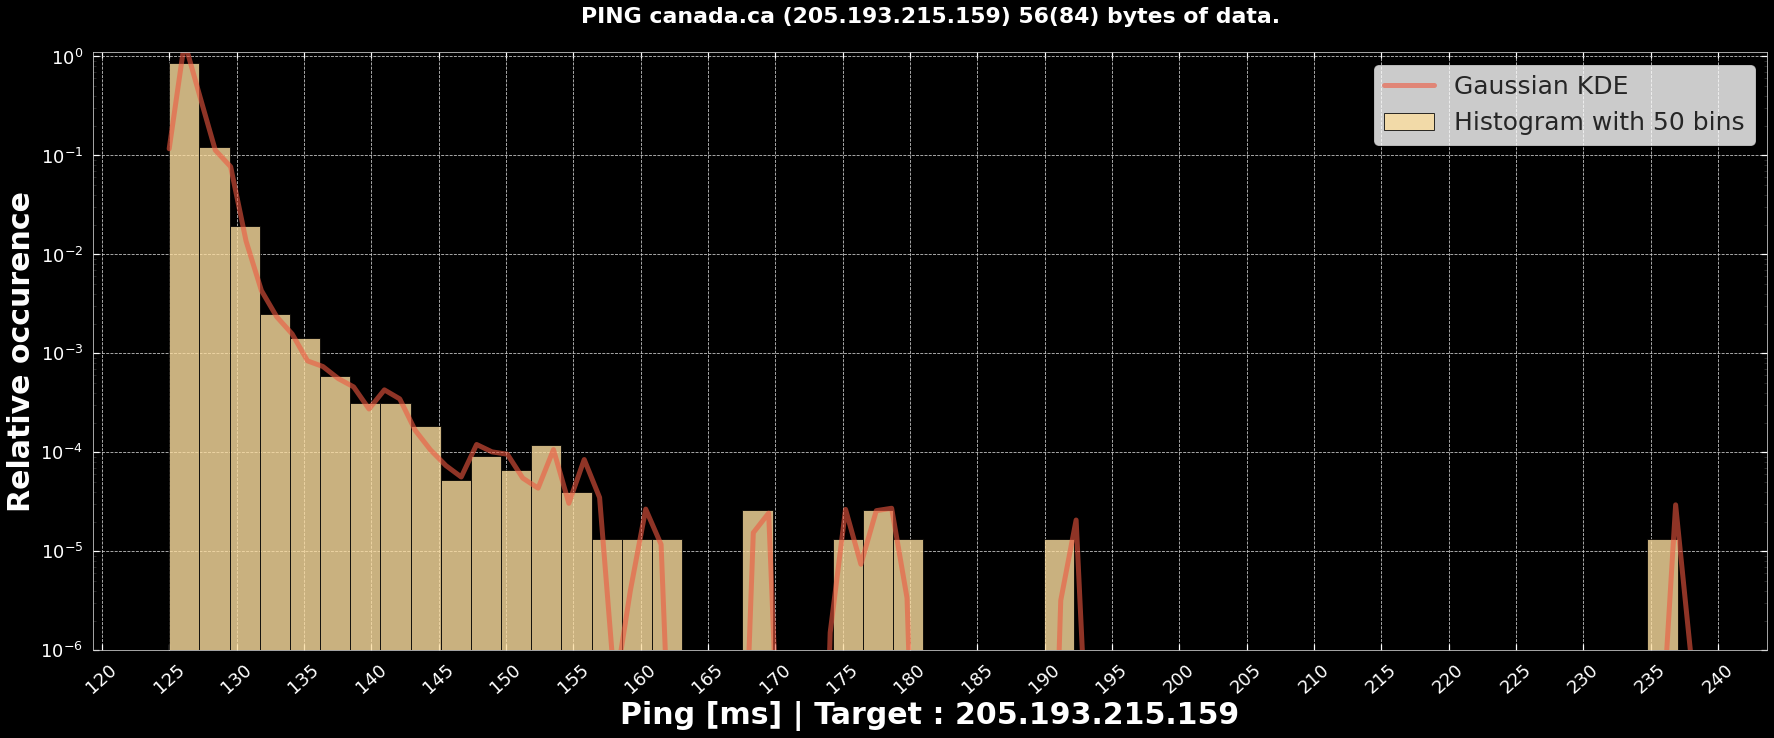

In [33]:
visualize_ping_histograms(df=df_1, header=header_1, bins=50)

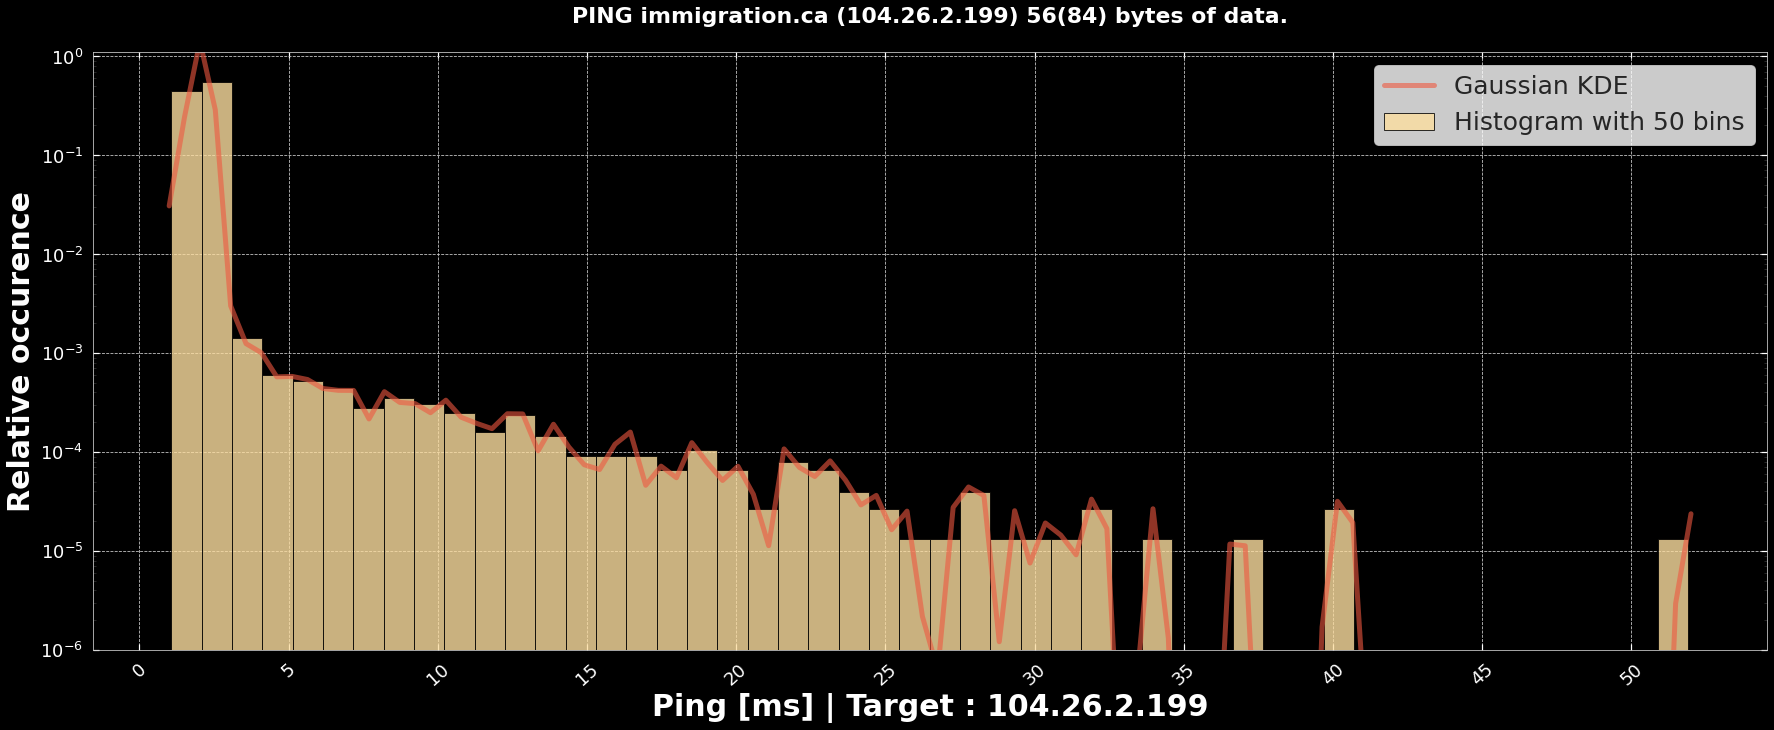

In [34]:
visualize_ping_histograms(df=df_2, header=header_2, bins=50)

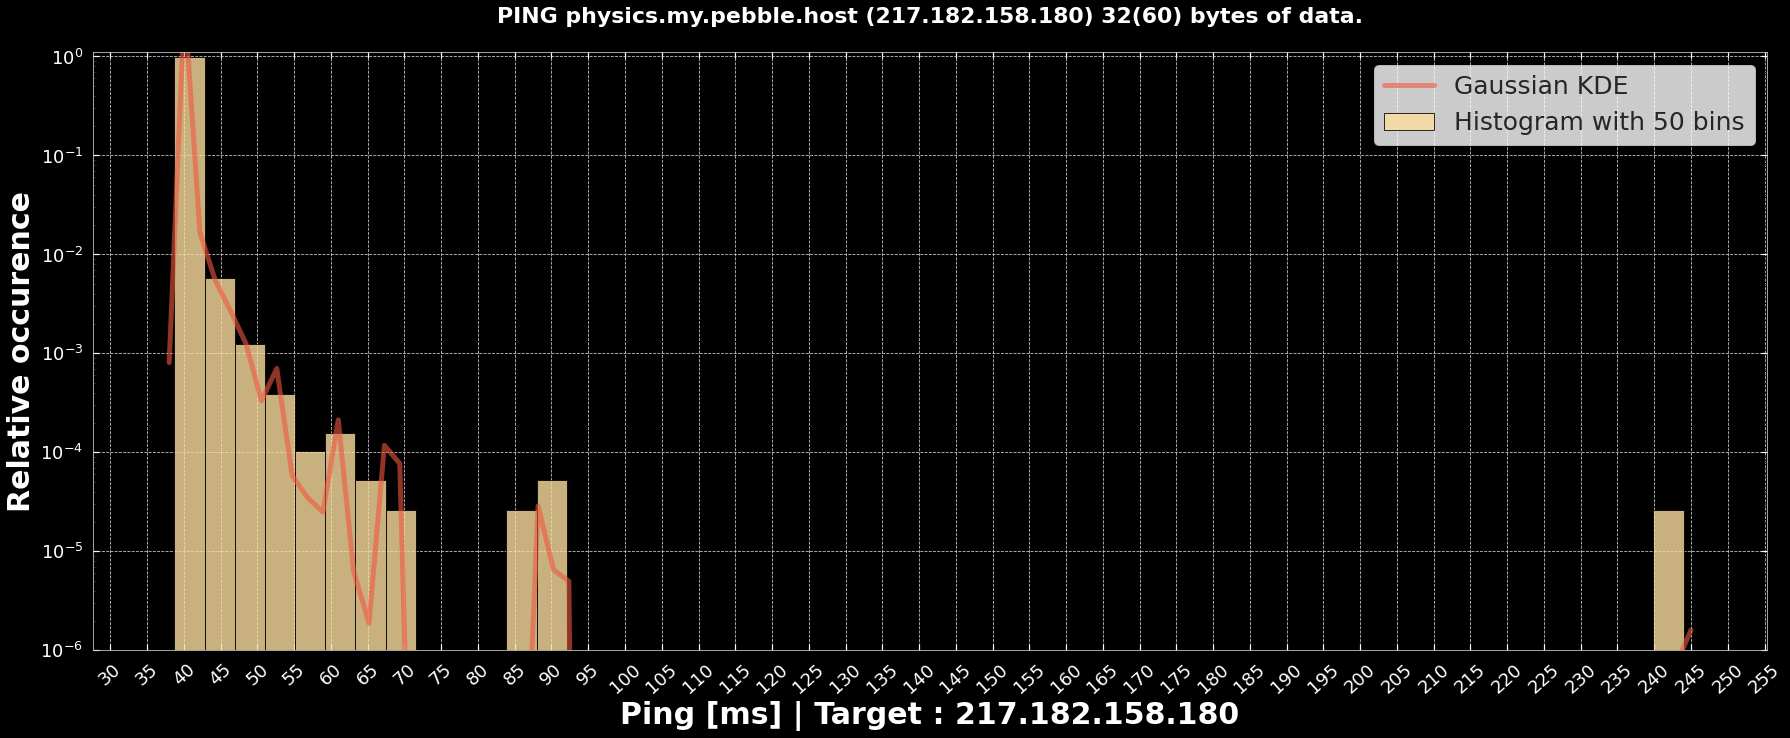

In [35]:
visualize_ping_histograms(df=df_3, header=header_3, bins=50)